C:\Users\theod\AppData\Local\Temp\ipykernel_16828\2920802227.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


[[[[ 0.  0.  0. ...  0.  0.  0.]
   [ 0. nan nan ... nan nan  0.]
   [ 0. nan nan ... nan nan  0.]
   ...
   [ 0. nan nan ... nan nan  0.]
   [ 0. nan nan ... nan nan  0.]
   [ 0.  0.  0. ...  0.  0.  0.]]

  [[ 0.  0.  0. ...  0.  0.  0.]
   [ 0. nan nan ... nan nan  0.]
   [ 0. nan nan ... nan nan  0.]
   ...
   [ 0. nan nan ... nan nan  0.]
   [ 0. nan nan ... nan nan  0.]
   [ 0.  0.  0. ...  0.  0.  0.]]]


 [[[ 0.  0.  0. ...  0.  0.  0.]
   [ 0. nan nan ... nan nan  0.]
   [ 0. nan nan ... nan nan  0.]
   ...
   [ 0. nan nan ... nan nan  0.]
   [ 0. nan nan ... nan nan  0.]
   [ 0.  0.  0. ...  0.  0.  0.]]

  [[ 0.  0.  0. ...  0.  0.  0.]
   [ 0. nan nan ... nan nan  0.]
   [ 0. nan nan ... nan nan  0.]
   ...
   [ 0. nan nan ... nan nan  0.]
   [ 0. nan nan ... nan nan  0.]
   [ 0.  0.  0. ...  0.  0.  0.]]]]


e:\Anaconda\envs\NSCode\lib\site-packages\matplotlib\image.py:463: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
e:\Anaconda\envs\NSCode\lib\site-packages\matplotlib\image.py:468: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact


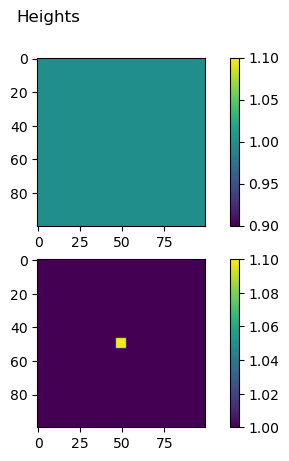

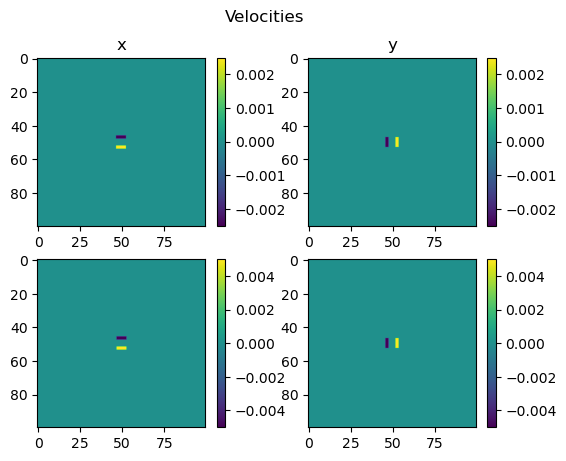

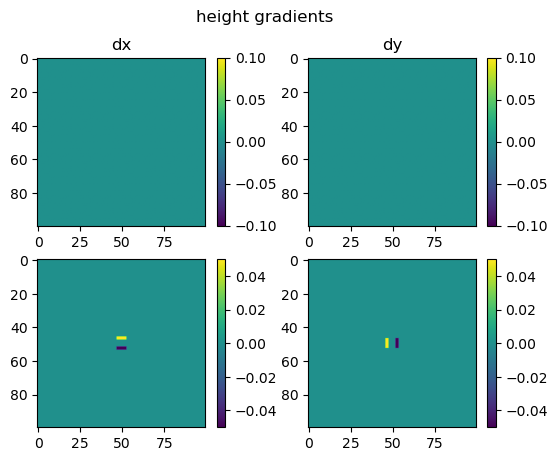

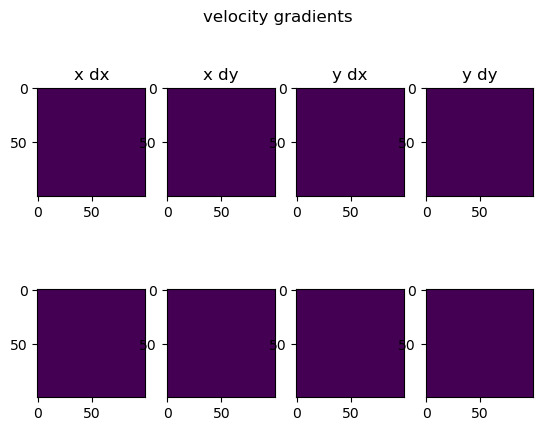

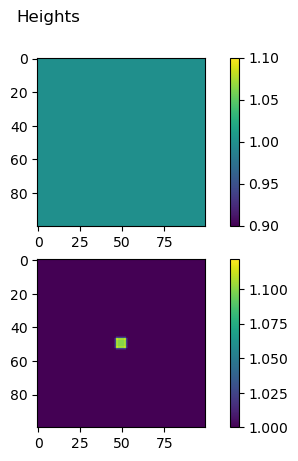

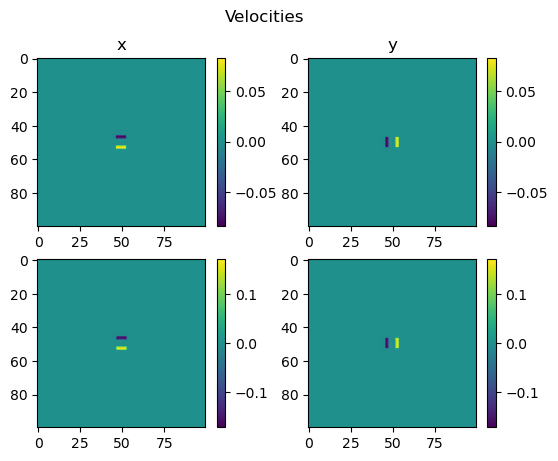

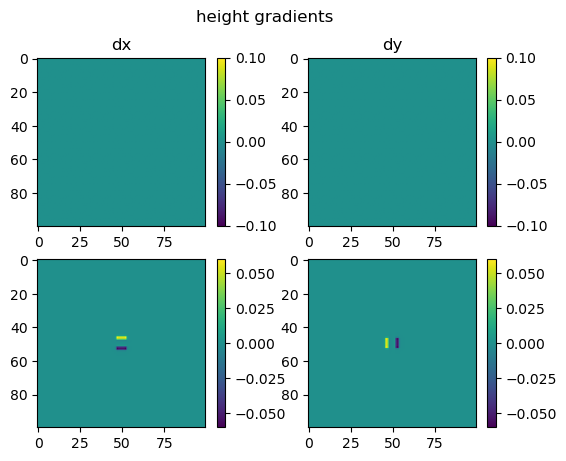

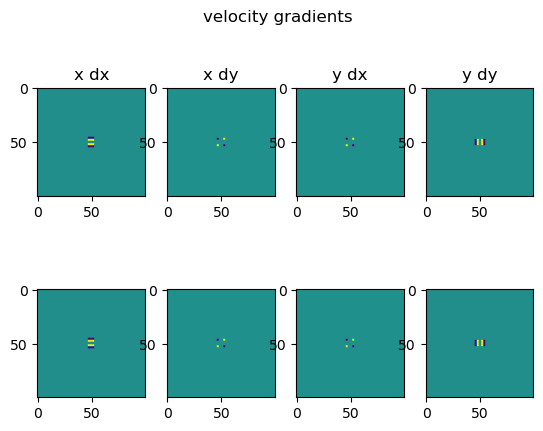

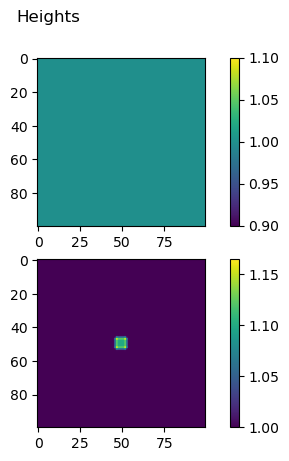

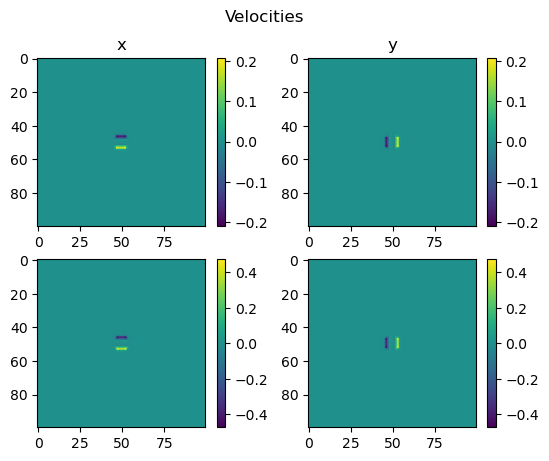

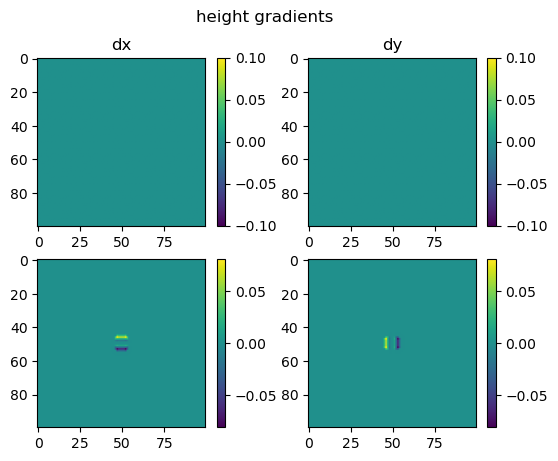

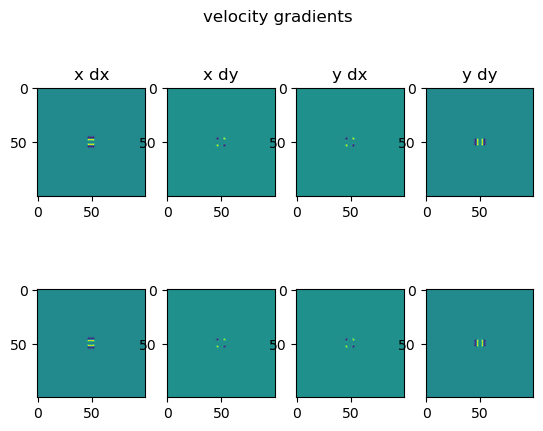

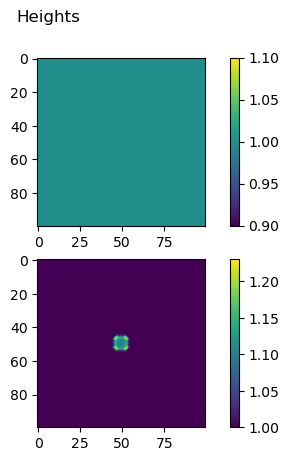

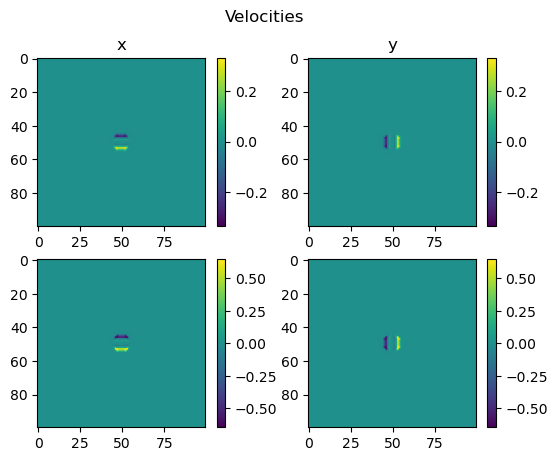

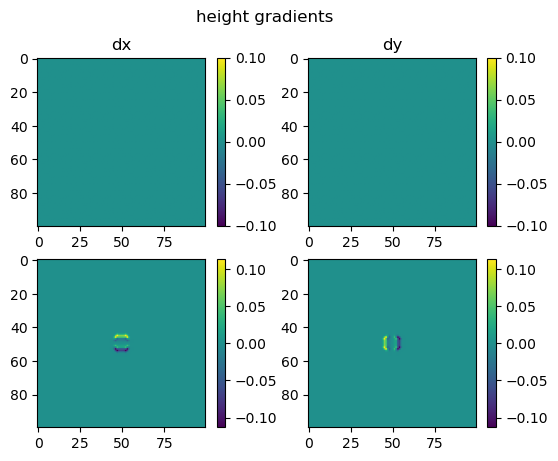

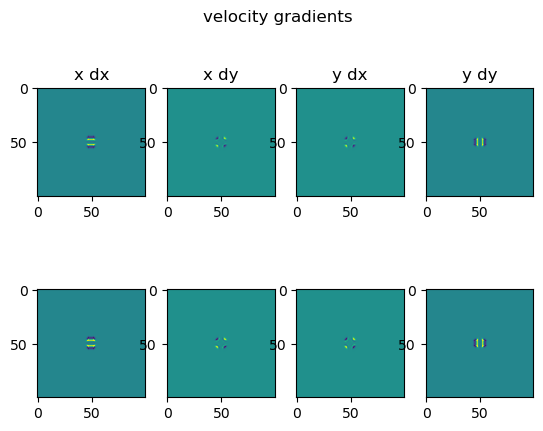

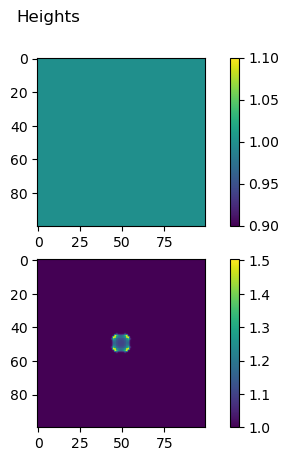

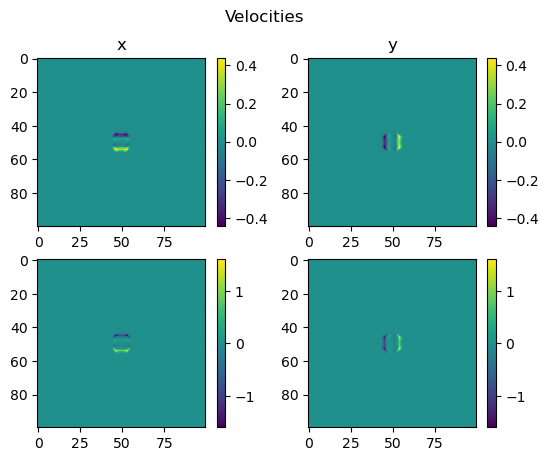

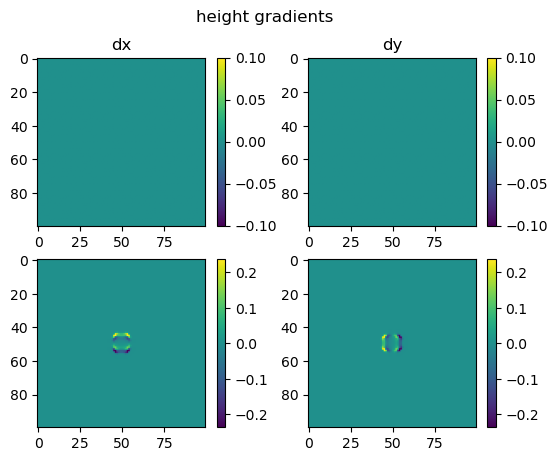

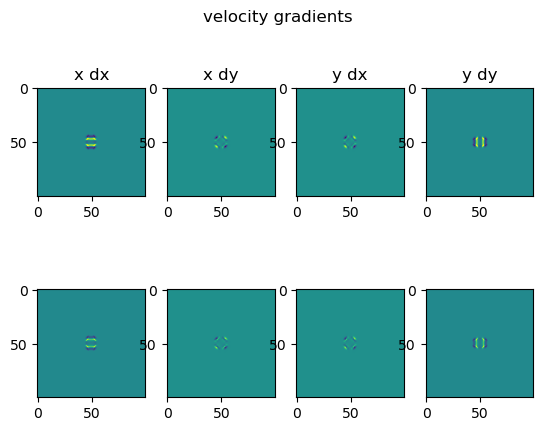

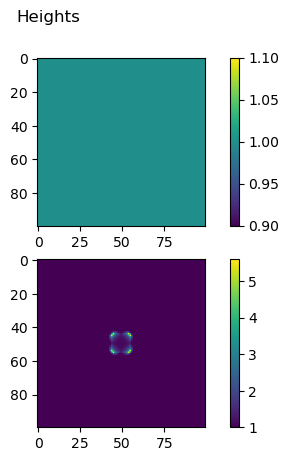

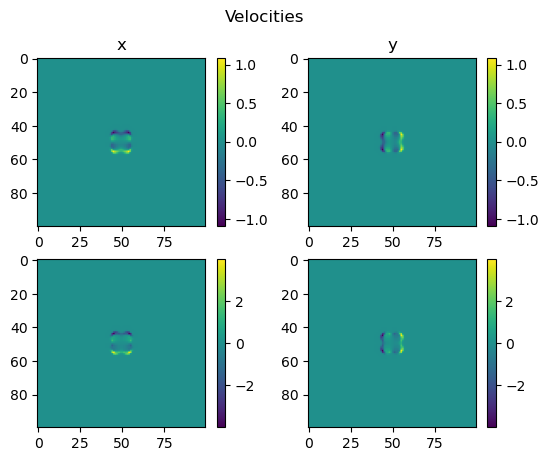

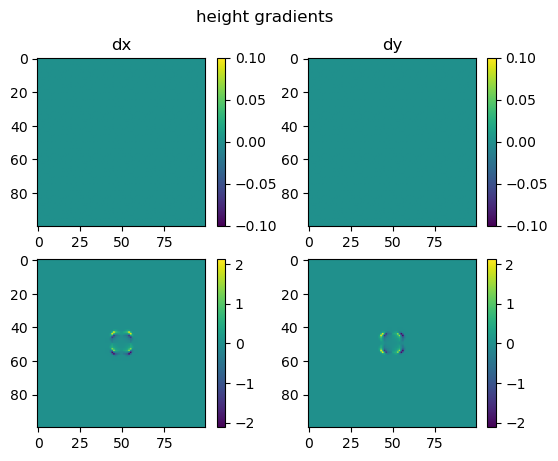

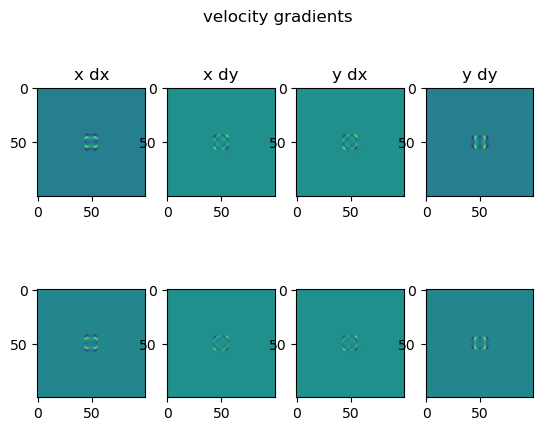

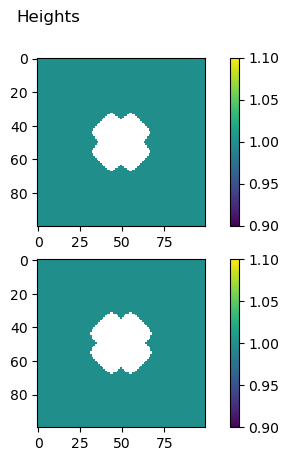

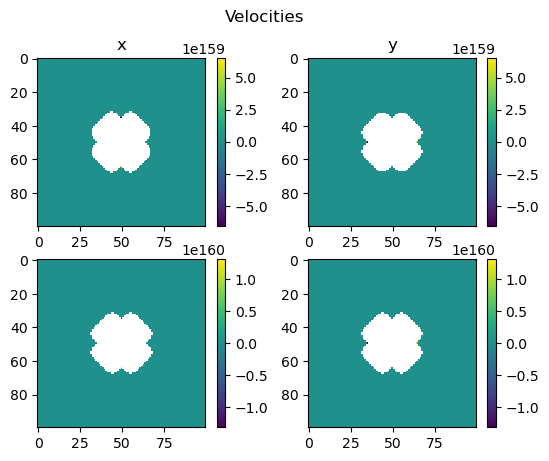

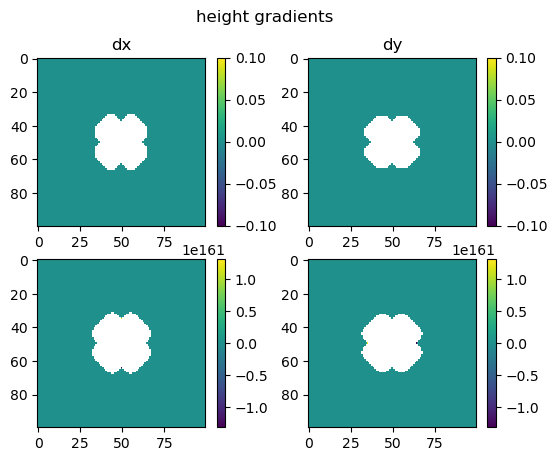

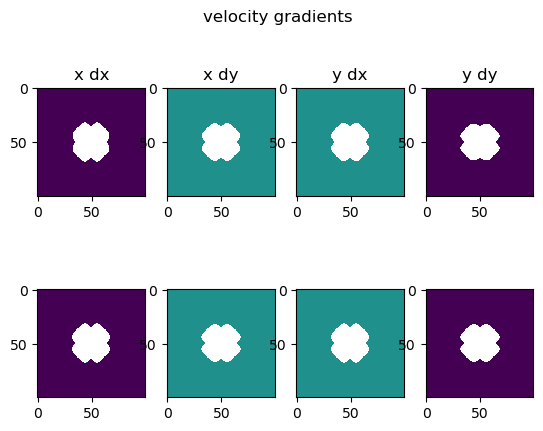

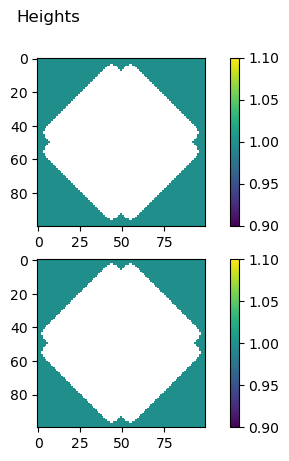

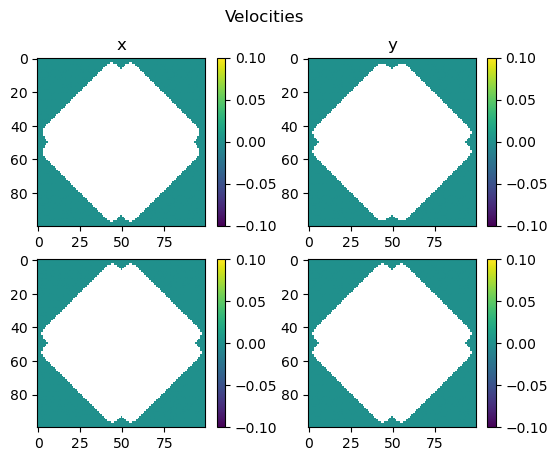

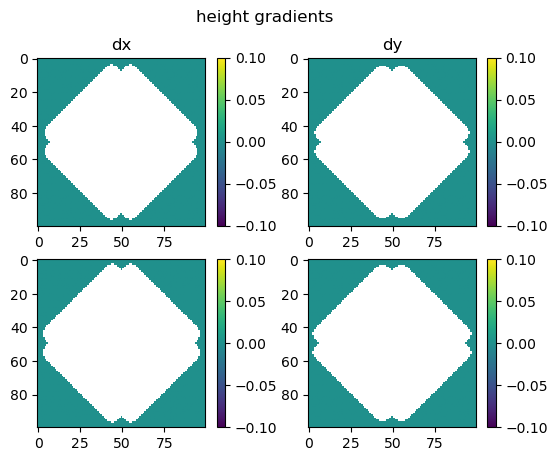

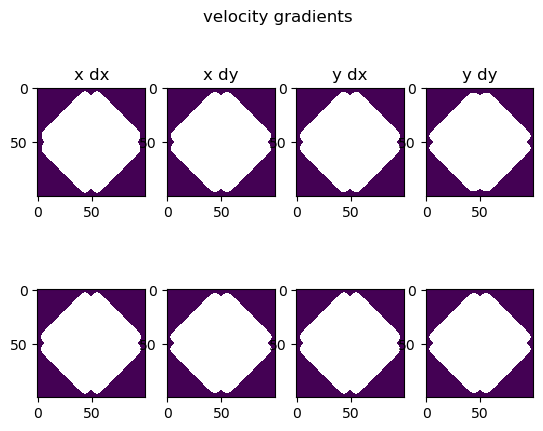

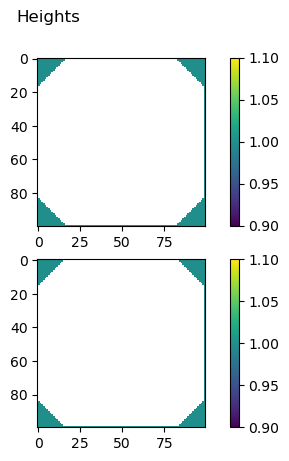

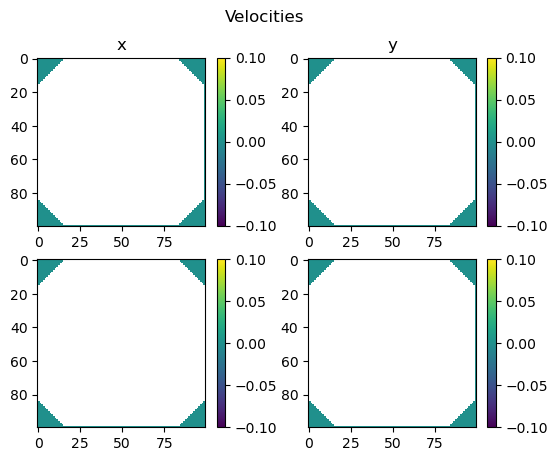

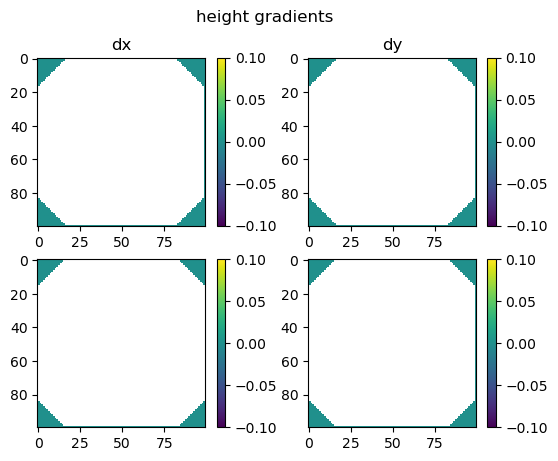

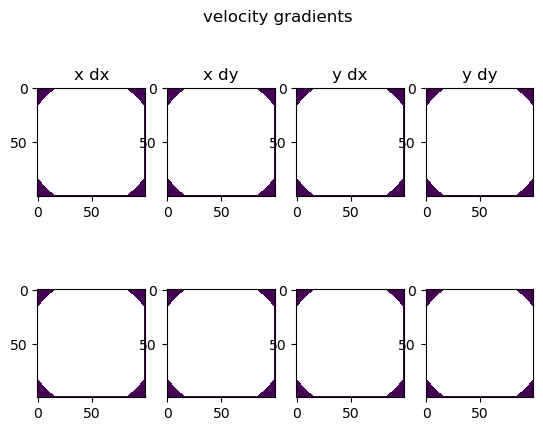

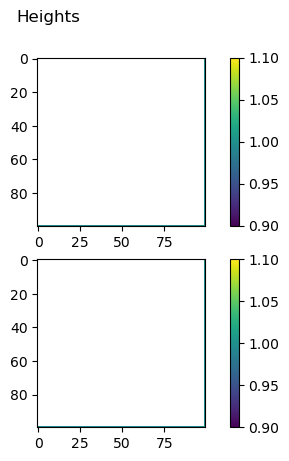

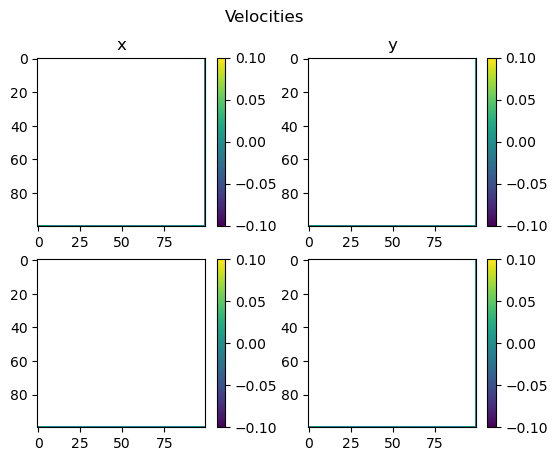

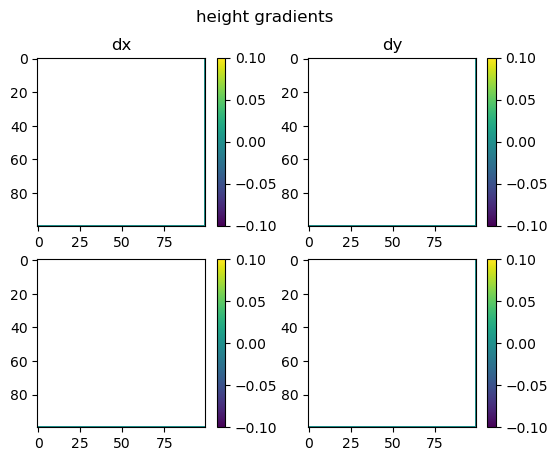

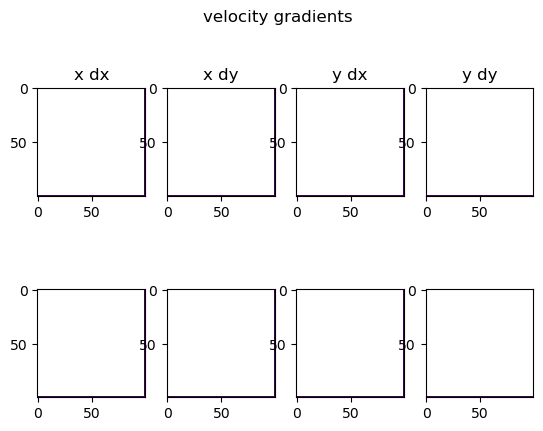

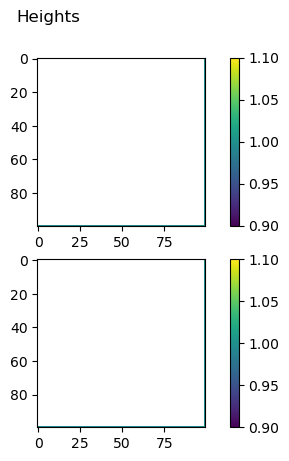

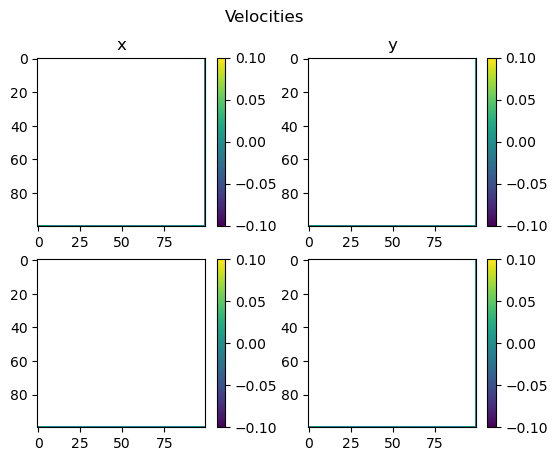

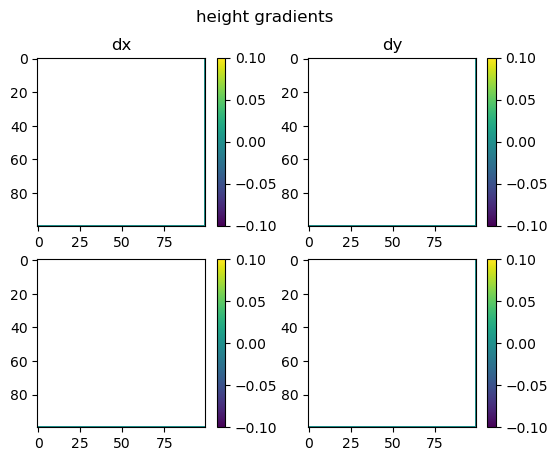

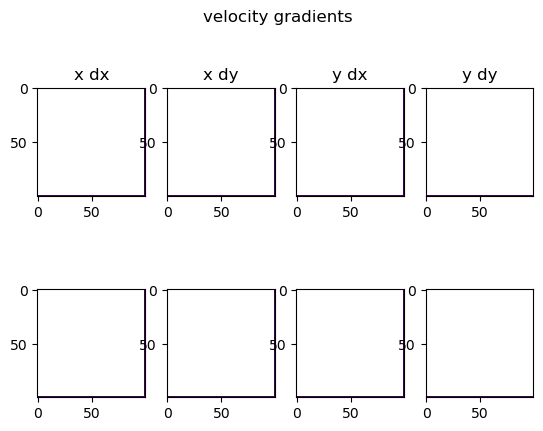

In [33]:
import numpy as np; import matplotlib.pyplot as plt; import numba as nb


# fixed density shallow water model

@nb.njit
def continuity_equation(layer_heights, layer_velocities, velocity_gradients, height_gradients, rho_factor, heating, dt):
    ix, iy, iz = layer_heights.shape
    for layer in range(ix):
        for ei in range(1, iy - 1, 1):
            for ej in range(1, iz - 1, 1):
                tmp = 0
                for axis in range(layer_velocities.shape[1]):
                    tmp += layer_velocities[layer, axis, ei, ej] * height_gradients[layer, axis, ei, ej]
                    # layer_heights[layer, ei, ej] * velocity_gradients[layer, axis, axis, ei, ej] + 
                    # (np.array((- rho_factor, 1))[layer] * heating[ei, ej]
                layer_heights[layer, ei, ej] += - dt * tmp

@nb.njit
def momentum_equation(layer_velocity, layer_heights, velocity_gradients, height_gradients, gravityfield_strength, rho_factor, dt, coriolis_parameter = 0, friction_coefficient = 0):
    ix, iy, iz, ik = layer_velocity.shape

    rho_matrix = np.array(((1,rho_factor), (1,1)))
    delta_array = np.zeros_like(layer_velocity)
    for layer in range(ix):
        for axis in range(iy):
            for xpos in range(1, iz - 1, 1):
                for ypos in range(1, ik - 1, 1):
                    tmp = 0 
                    for grad in range(2):
                        tmp += layer_velocity[layer, grad, xpos, ypos] * velocity_gradients[layer, axis, grad, xpos, ypos]

                    height_flux = 0
                    for height_layer in range(layer_heights.shape[0]):
                        height_flux += height_gradients[height_layer, axis, xpos, ypos] * rho_matrix[layer, height_layer]
                    # issue is here!?!?!?!
                    # this part does some weird stuff
                    delta_array[layer, axis, xpos, ypos] = dt * ( - gravityfield_strength * height_flux - tmp\
                        + coriolis_parameter*layer_velocity[layer, axis - 1, xpos, ypos] + friction_coefficient)
    
    for layer in range(ix):
        for axis in range(iy):
            for xpos in range(1, iz - 1, 1):
                for ypos in range(1, ik - 1, 1):
                    layer_velocity[layer, axis, xpos, ypos] += delta_array[layer, axis, xpos, ypos]

@nb.njit
def gradients(layer_heights, layer_velocities, velocity_gradients, height_gradients, dx, dy):
    # using the central difference scheme currently
    ix, iy, iz, ij, ik = velocity_gradients.shape
    jx, jy, jz, jk = height_gradients.shape
    # need to generate a boundary layer


    for layer in range(ix):
        for vel_dir in range(iy):
            for grad_dir in range(iz):
                if grad_dir == 0:
                    for xpos in range(1, ij - 1, 1):
                        for ypos in range(1, ik - 1, 1):
                            velocity_gradients[layer, vel_dir, grad_dir, xpos, ypos] = (1/(2*dx)) * \
                                (layer_velocities[layer, vel_dir, xpos + 1, ypos] - layer_velocities[layer, vel_dir, xpos - 1, ypos])
                
                if grad_dir == 1:
                    for xpos in range(1, ij - 1, 1):
                        for ypos in range(1, ik - 1, 1):
                            velocity_gradients[layer, vel_dir, grad_dir, xpos, ypos] = (1/(2*dy)) * \
                                (layer_velocities[layer, vel_dir, xpos, ypos + 1] - layer_velocities[layer, vel_dir, xpos, ypos - 1])

    for layer in range(jx):
        for grad_dir in range(jy):
            if grad_dir == 0:
                for xpos in range(1, jz - 1, 1):
                    for ypos in range(1, jk - 1, 1):
                        height_gradients[layer, grad_dir, xpos, ypos] = (1/(2*dx)) * (layer_heights[layer, xpos + 1, ypos] - layer_heights[layer, xpos - 1, ypos])

            if grad_dir == 1:
                for xpos in range(1, jz - 1, 1):
                    for ypos in range(1, jk - 1, 1):
                        height_gradients[layer, grad_dir, xpos, ypos] = (1/(2*dy)) * ( layer_heights[layer, xpos, ypos + 1] - layer_heights[layer, xpos, ypos - 1])

# set densities
rho_0 = 1e2; rho_factor = 0.5

# set the mesh size
grid_size = 100

# mesh properties
x_length = 1e2; y_length = 1e2
dx = x_length/grid_size; dy = y_length/grid_size; dt = 1e-1

dirs = ['x', 'y']
grads = ['dx','dy']

# create the velocity fields
layervelocity = np.zeros((2,2,grid_size, grid_size))
layervelocity_gradients = np.zeros((2,2,2,grid_size, grid_size))
# why 5D array
# dim1 -> layer number
# dim2 -> velocity direction
# dim3 -> gradient direction
# dim4/5 -> spacial position
# create the height fields
layerheight = np.ones((2,grid_size, grid_size))
height_gradients = np.zeros((2,2,grid_size, grid_size)) 

# # hydrostatic equilibrium 
# # p_1 = g * rho * (h_1 + rho_factor * h_2)
# # p_2 = rho_factor * g * rho * (h_1 + h_2)
# p_0 = p_1 = np.zeros((2,grid_size, grid_size))

iterations = int(30 // dt)
heating_mesh = np.zeros((grid_size, grid_size))
layerheight[1, grid_size//2 - 3:grid_size//2 + 3, grid_size//2 - 3:grid_size//2 + 3] = 1.1
# heating_mesh[grid_size//2 - 3:grid_size//2 + 3, grid_size//2 - 3:grid_size//2 + 3] = 0.1
gravityfield = 1

for ia in range(iterations):
    gradients(layer_heights=layerheight, layer_velocities= layervelocity, velocity_gradients= layervelocity_gradients, height_gradients= height_gradients, dx = dx, dy =dy)
    continuity_equation(layer_heights= layerheight, layer_velocities= layervelocity, velocity_gradients= layervelocity_gradients, height_gradients= height_gradients, rho_factor= rho_factor, heating= heating_mesh/gravityfield, dt = dt)
    momentum_equation(layer_velocity= layervelocity, layer_heights= layerheight, velocity_gradients= layervelocity_gradients, height_gradients= height_gradients, gravityfield_strength=gravityfield, rho_factor=rho_factor, dt = dt)
    
    if ia % (iterations // 10) == 0:
        fig = plt.figure()
        fig.suptitle('Heights')
        axs = [fig.add_subplot(2,1, i) for i in range(1,3,1)]
        for index, ax in enumerate(axs):
            scat = ax.imshow(layerheight[index])
            plt.colorbar(scat)

        fig = plt.figure()
        fig.suptitle('Velocities')
        axs = [fig.add_subplot(2,2,i) for i in range(1,5,1)]
        for index, ax in enumerate(axs):
            ind = np.unravel_index(index, (2,2))
            if ind[0] == 0:
                ax.set_title(dirs[ind[1]])
            scat = ax.imshow(layervelocity[ind[0],ind[1]])
            plt.colorbar(scat)

        fig = plt.figure()
        axs = [fig.add_subplot(2,2,i) for i in range(1,5,1)]
        fig.suptitle('height gradients')
        for index, ax in enumerate(axs):
            ind = np.unravel_index(index, (2,2))
            if ind[0] == 0:
                ax.set_title(grads[ind[1]])
            scat = ax.imshow(height_gradients[ind[0],ind[1]])
            plt.colorbar(scat)
            
        fig = plt.figure()
        fig.suptitle('velocity gradients')
        axs = [fig.add_subplot(2,4,i) for i in range(1,2*4 + 1,1)]
        for index, ax in enumerate(axs):
            ind = np.unravel_index(index, (2,2,2))
            if ind[0] == 0:
                ax.set_title('{} {}'.format(dirs[ind[1]], grads[ind[2]]))
            scat = ax.imshow(layervelocity_gradients[ind[0], ind[1], ind[2]])
    
print(height_gradients)


In [64]:
grid_points = 50; dx = 1e2; dt = 1e0
velocity_field = height_field = np.zeros((grid_points))

def gradient_STORE()


0 1
